In [2]:
import os
import sys
import json
import importlib
import copy
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

In [3]:
with open('./paths', 'r') as f:
    globals().update(json.loads(f.read()))

In [4]:
sys.path.append(path_Modules_Product_)
sys.path.append(path_Modules_Toolbox_)

In [5]:
import data_processing as myprep
import handles as myhandles
import plots as myplots
import uncertainty as myuncertainty


In [6]:
import keras.layers as klayers
import keras.models as kmodels
import keras.callbacks as kcallbacks
import keras.regularizers as kregularizers
import keras.losses as kloss
import keras.backend as K

from sklearn import preprocessing as skprep
from sklearn import metrics as skmet

K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


[]

In [7]:
dataset = myhandles.canseek_load(
    path_data_proprocessed_, folds=[[0, 1, 2], [3]])
ddef = pd.read_excel(path_data_proprocessed_ +
                     'dataset_main.xlsx', sheet_name=1, index_col=0)
cancer_sets = ['Colorectum', 'Lung', 'Breast', 'Ovary', 'Stomach', 'Esophagus']
normal_set = 'Normal'
all_sets = copy.deepcopy(cancer_sets)
all_sets.append(normal_set)

for i in [0, 1, 2]:
    dataset[i] = myhandles.subset_selector(dataset[i], all_sets, 'T1')

# DropOut Variational Inference

In [8]:
features = [['F1', 'F2'], ['IL-8', 'Prolactin','IL-6','OPN']]
features[1] = myhandles.name_to_alias(features[1], ddef)
features_set = np.concatenate(features)
targets = [['S1', 'S2', 'S3']]
targets_set = np.concatenate(targets)
data_set = np.concatenate([features_set, targets_set])

In [9]:
dataset_ = copy.deepcopy(dataset)
for i in range(3):
    dataset_[i]['S1'] = (dataset_[i].T2 > 0).astype(int)
    dataset_[i]['S2'] = (dataset_[i].T2 > 1).astype(int)
    dataset_[i]['S3'] = (dataset_[i].T2 > 2).astype(int)

for i in range(3):
    dataset_[i] = dataset_[i].dropna(subset=data_set).copy()
transformer = {
    myprep.age_transformer(): ['F1'],
    skprep.OrdinalEncoder(): ['F2'],
    skprep.QuantileTransformer(): features[1]
}
transformer = myprep.PipeTransform(transformer, dataset_[0])
dataset_trans = copy.deepcopy(dataset_)
for i in range(3):
    dataset_trans[i] = transformer.transform(dataset_[i])

X_train = myhandles.dataset_generator(dataset_trans[0], features)
X_dev = myhandles.dataset_generator(dataset_trans[1], features)
Y_train = myhandles.dataset_generator(dataset_trans[0], targets)
Y_dev = myhandles.dataset_generator(dataset_trans[1], targets)
X_pnas = myhandles.dataset_generator(dataset_trans[2], features)

In [10]:
dout = 0.3

in_demo = klayers.Input(shape=(2,), name='input_demo')
in_prot = klayers.Input(shape=(X_train[1].shape[1],), name='input_prot')

l1 = klayers.BatchNormalization(name='demo_BN')(in_demo)
l1 = klayers.Dense(16, activation='selu',
                   kernel_initializer='lecun_normal', name='demo_H1')(l1)
l = klayers.AlphaDropout(dout, name='demo_D1')(l1, training=True)
l2 = klayers.BatchNormalization(name='prot_BN')(in_prot)
l2 = klayers.Dense(32, activation='selu',
                   kernel_initializer='lecun_normal', name='prot_H1')(l2)
l = klayers.AlphaDropout(dout, name='prot_D1')(l2, training=True)
l2 = klayers.Dense(32, activation='selu',
                   kernel_initializer='lecun_normal', name='prot_H2')(l2)
l = klayers.AlphaDropout(dout, name='prot_D2')(l2, training=True)

l = klayers.Concatenate(name='Concate')([l1, l2])
l = klayers.BatchNormalization(name='BN0')(l)
# l = klayers.AlphaDropout(dout, name='D0')(l, training=True)

l = klayers.Dense(64, activation='selu', kernel_initializer='lecun_normal',
                  name='H1', kernel_regularizer=kregularizers.l2(0.005))(l)
l = klayers.AlphaDropout(dout, name='D1')(l, training=True)

l = klayers.BatchNormalization(name='BN1')(l)

S = klayers.Dense(3, activation='sigmoid', name="Stage")(l)

model = kmodels.Model(inputs=[in_demo, in_prot], outputs=[S])
model.compile('adam', ['binary_crossentropy'])
es = kcallbacks.EarlyStopping(patience=20)
tb = kcallbacks.TensorBoard(
    '/home/amir/TensorBoards/A/{}'.format(int(time.time())), histogram_freq=1, write_grads=True)
h = model.fit(X_train, Y_train, batch_size=64, epochs=1000,
              validation_data=(X_dev, Y_dev), callbacks=[es], class_weight={0: 1})

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 1132 samples, validate on 368 samples
Epoch 1/1000
1132/1132 [==============================] - 1s 760us/step - loss: 1.0383 - val_loss: 0.8719
Epoch 2/1000
1132/1132 [==============================] - 0s 64us/step - loss: 0.8671 - val_loss: 0.8190
Epoch 3/1000
1132/1132 [==============================] - 0s 41us/step - loss: 0.7780 - val_loss: 0.7718
Epoch 4/1000
1132/1132 [==============================] - 0s 33us/step - loss: 0.7627 - val_loss: 0.7369
Epoch 5/1000
1132/1132 [==============================] - 0s 41us/step - loss: 0.7183 - val_loss: 0.7153
Epoch 6/1000
1132/1132 [==============================] - 0s 40us/step - loss: 0.6840 - val_loss: 0.6624
Epoch 7/1000
1132/1132 [==============================] - 0s 39us/step - loss: 0.6615 - val_loss: 0.6384
Epoch 8/1000
1132/1132 [==============================] - 0s 38us/step - loss: 0.6332 - val_loss:

1132/1132 [==============================] - 0s 48us/step - loss: 0.3603 - val_loss: 0.3746
Epoch 73/1000
1132/1132 [==============================] - 0s 36us/step - loss: 0.3631 - val_loss: 0.3835
Epoch 74/1000
1132/1132 [==============================] - 0s 38us/step - loss: 0.3618 - val_loss: 0.3774
Epoch 75/1000
1132/1132 [==============================] - 0s 36us/step - loss: 0.3678 - val_loss: 0.3794
Epoch 76/1000
1132/1132 [==============================] - 0s 39us/step - loss: 0.3634 - val_loss: 0.3733
Epoch 77/1000
1132/1132 [==============================] - 0s 33us/step - loss: 0.3599 - val_loss: 0.3782
Epoch 78/1000
1132/1132 [==============================] - 0s 38us/step - loss: 0.3594 - val_loss: 0.3767
Epoch 79/1000
1132/1132 [==============================] - 0s 39us/step - loss: 0.3513 - val_loss: 0.3762
Epoch 80/1000
1132/1132 [==============================] - 0s 35us/step - loss: 0.3580 - val_loss: 0.3763
Epoch 81/1000
1132/1132 [==============================] - 0

Epoch 149/1000
1132/1132 [==============================] - 0s 37us/step - loss: 0.3429 - val_loss: 0.3629
Epoch 150/1000
1132/1132 [==============================] - 0s 35us/step - loss: 0.3342 - val_loss: 0.3459
Epoch 151/1000
1132/1132 [==============================] - 0s 37us/step - loss: 0.3379 - val_loss: 0.3626
Epoch 152/1000
1132/1132 [==============================] - 0s 36us/step - loss: 0.3373 - val_loss: 0.3534
Epoch 153/1000
1132/1132 [==============================] - 0s 38us/step - loss: 0.3311 - val_loss: 0.3528
Epoch 154/1000
1132/1132 [==============================] - 0s 37us/step - loss: 0.3344 - val_loss: 0.3572
Epoch 155/1000
1132/1132 [==============================] - 0s 39us/step - loss: 0.3299 - val_loss: 0.3602
Epoch 156/1000
1132/1132 [==============================] - 0s 36us/step - loss: 0.3320 - val_loss: 0.3538
Epoch 157/1000
1132/1132 [==============================] - 0s 38us/step - loss: 0.3370 - val_loss: 0.3542
Epoch 158/1000
1132/1132 [===========

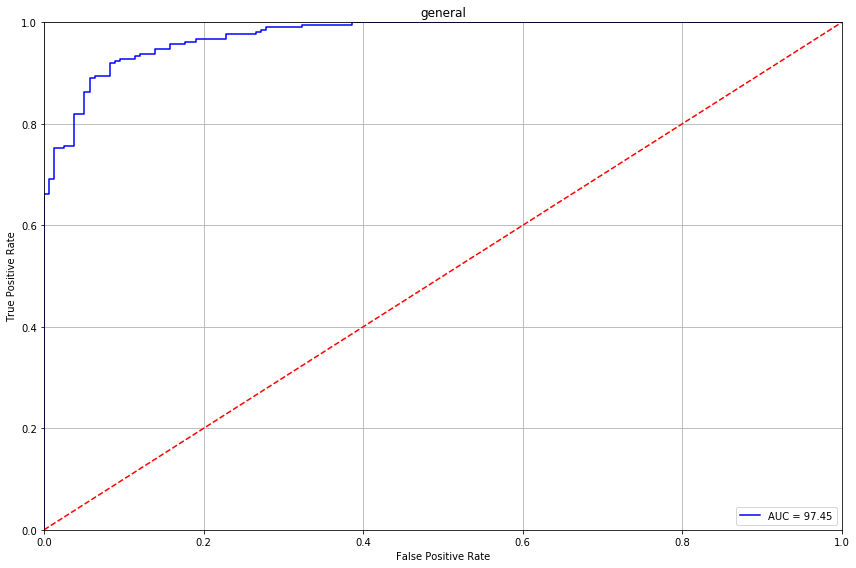

PNAS controls result:


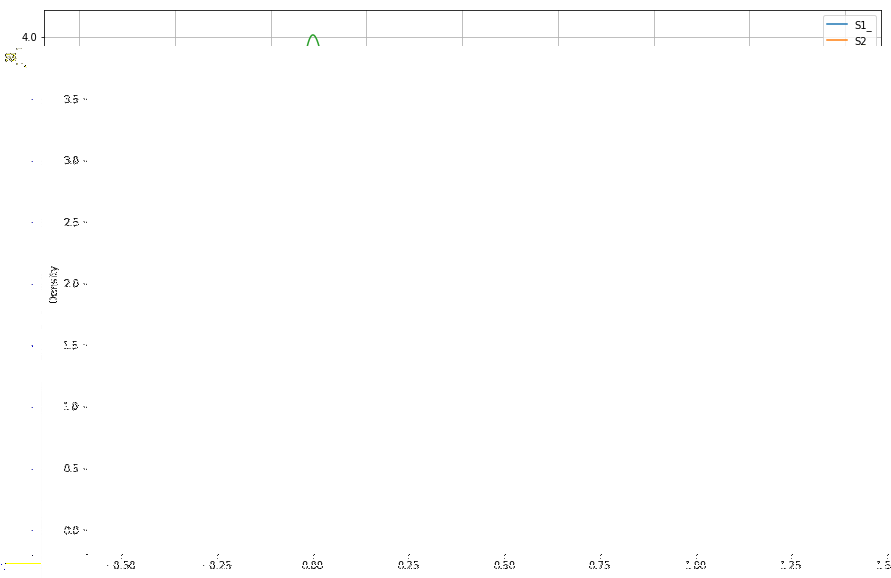

S1_: 120.0 of 180 | error = 0.6666666666666666 | log-loss = 1.6785656


,S1_,S2_,S3_
count,180.000000,180.000000,180.000000
mean,0.646861,0.456725,0.181754
std,0.275403,0.217845,0.104368
min,0.004815,0.019514,0.011569
25%,0.428013,0.297265,0.100385
50%,0.670659,0.431348,0.156786
75%,0.907975,0.625622,0.263259
max,0.997933,0.867357,0.441492


In [11]:
res = dataset_trans[1].copy()
res['S1_'], res['S2_'], res['S3_'] = None, None, None
res[['S1_', 'S2_', 'S3_']] = model.predict(X_dev)
plt.figure(figsize=(15, 10))
myplots.training_plot(h.history)
myplots.binroc_multiple(res, 'S1', 'S1_', 'T1', cancer_sets, normal_set)
plt.show()
# -------------------------------
print('PNAS controls result:')
res_pnas = model.predict(X_pnas)
res_pnas = pd.DataFrame(res_pnas, columns=['S1_', 'S2_', 'S3_'])
res_pnas.plot.kde(grid=True, figsize=(15, 10))
plt.show()
res_pnas.describe()
pnas_bool = np.round(res_pnas['S1_'])
print('S1_:', pnas_bool.sum(), 'of', len(res_pnas), '| error =', pnas_bool.sum(
)/len(pnas_bool), '| log-loss =', -np.log(1-res_pnas['S1_']).mean())
res_pnas.describe()

In [12]:
prob_data=[]
for d in dataset_trans:
    prob_data.append(d.copy())
    tmp=myuncertainty.drop_vi(model,myhandles.dataset_generator(d,features),100)
    prob_data[-1]['S1_']=tmp[0][0][:,0]
    prob_data[-1]['S1_al']=tmp[0][1][:,0]
    prob_data[-1]['S1_ep']=tmp[0][2][:,0]

TN:


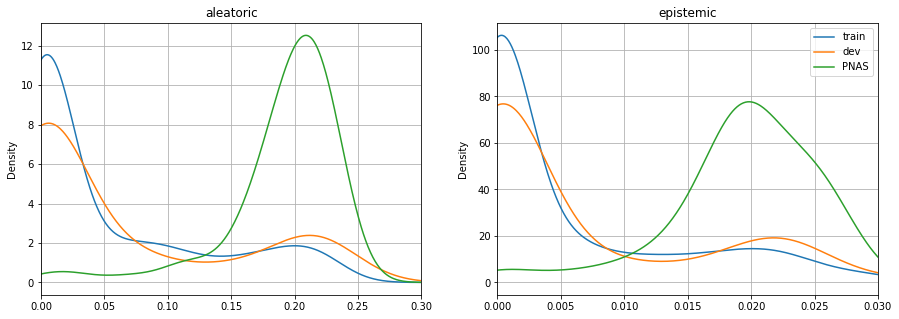

FP:


FN:


TP:


In [13]:
print('TN:')
plt.figure(figsize=(15,5))
al_ax=plt.subplot(121)
plt.title('aleatoric')
plt.xlim((0,.3))
ep_ax=plt.subplot(122)
plt.title('epistemic')
plt.xlim((0,.03))
for d in prob_data[:]:
    tmp=d.loc[np.logical_and(d.S1==0,d.S1_<.5)]
    tmp['S1_al'].plot.kde(ax=al_ax,grid=True)
    tmp['S1_ep'].plot.kde(ax=ep_ax,grid=True)
plt.legend(['train','dev','PNAS'])
plt.show()

print('FP:')
plt.figure(figsize=(15,5))
al_ax=plt.subplot(121)
plt.title('aleatoric')
plt.xlim((0,.3))
ep_ax=plt.subplot(122)
plt.title('epistemic')
plt.xlim((0,.03))
for d in prob_data[:]:
    tmp=d.loc[np.logical_and(d.S1==0,d.S1_>.5)]
    tmp['S1_al'].plot.kde(ax=al_ax,grid=True)
    tmp['S1_ep'].plot.kde(ax=ep_ax,grid=True)
plt.legend(['train','dev','PNAS'])
plt.show()

print('FN:')
plt.figure(figsize=(15,5))
al_ax=plt.subplot(121)
plt.title('aleatoric')
plt.xlim((0,.3))
ep_ax=plt.subplot(122)
plt.title('epistemic')
plt.xlim((0,.03))
for d in prob_data[:2]:
    tmp=d.loc[np.logical_and(d.S1==1,d.S1_<.5)]
    tmp['S1_al'].plot.kde(ax=al_ax,grid=True)
    tmp['S1_ep'].plot.kde(ax=ep_ax,grid=True)
plt.legend(['train','dev'])
plt.show()

print('TP:')
plt.figure(figsize=(15,5))
al_ax=plt.subplot(121)
plt.title('aleatoric')
plt.xlim((0,.3))
ep_ax=plt.subplot(122)
plt.title('epistemic')
plt.xlim((0,.03))
for d in prob_data[:2]:
    tmp=d.loc[np.logical_and(d.S1==1,d.S1_>.5)]
    tmp['S1_al'].plot.kde(ax=al_ax,grid=True)
    tmp['S1_ep'].plot.kde(ax=ep_ax,grid=True)
plt.legend(['train','dev'])
plt.show()